In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error,mean_squared_error
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
trans = pd.read_csv("transactions.csv",dtype={'store_nbr': 'category'},infer_datetime_format=True, parse_dates=['date'])
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))
data_oil = pd.read_csv('oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')

calendar = calendar.merge(data_oil, left_index=True, right_index=True, how='outer')
calendar['dcoilwtico'] = calendar['dcoilwtico'].interpolate()
calendar['ma_oil'] = calendar.rolling(7,min_periods = 1).mean()


# add lagging
for i in range(1, 6):
    calendar[f'ma_oil_lag{i}'] = calendar['ma_oil'].shift(i)



# read holidays events
data_holiday = pd.read_csv('holidays_events.csv', parse_dates=['date'])

# 'Good Friday' mistake correction
data_holiday['date'][data_holiday.description=='Viernes Santo'].replace({'2013-04-29': pd.to_datetime('2013-03-29')}, inplace=True)
data_holiday = data_holiday.set_index('date').sort_index()
# keep National level only for simplicity
data_holiday = data_holiday[data_holiday.locale=='National']
# keep only one event per day
data_holiday = data_holiday.groupby(data_holiday.index).first()




# merge data_holiday
calendar = calendar.merge(data_holiday, how='left', left_index=True, right_index=True)
calendar = calendar.rename(columns={"type": "holiday_type"})

# create a True/False feature calendar['workday'] to indicate whether each date is a workday
calendar['workday'] = calendar.index.weekday<5
# friday bridges are not working days
calendar.loc[calendar.holiday_type=='Bridge', 'workday'] = False
# some bridges are recovered by working at weekends
calendar.loc[calendar.holiday_type=='Work Day', 'workday'] = True
# handling Transfered events
calendar.loc[calendar.holiday_type=='Transfer', 'workday'] = False
calendar.loc[(calendar.holiday_type=='Holiday')&(calendar.transferred==False), 'workday'] = False
calendar.loc[(calendar.holiday_type=='Holiday')&(calendar.transferred==True ), 'workday'] = True
# change to numerical
calendar['workday'] = calendar['workday'] * 1
calendar['dayofweek'] = calendar.index.day_of_week.astype('int')

# drop un-used info from calendar
calendar.drop(columns=['dcoilwtico', 'locale', 'locale_name', 'description', 'transferred'], inplace=True)

# encode categorical features
calendar = pd.get_dummies(calendar, columns=['holiday_type'], drop_first=False)
calendar = pd.get_dummies(calendar, columns=['dayofweek'], drop_first=False)




df_train = pd.read_csv( 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

df_train.head(15)

df_test = pd.read_csv('test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test.date = df_test.date.dt.to_period('D')

df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

df_test.head(15) # display some entries of the testing data


calendar.index = calendar.index.to_period('D')

def xy_compute(storesX,storesY):
    train_sdate = '2013-01-02'
    train_edate = df_train.index.get_level_values('date').max()
    y = storesY.unstack(['store_nbr','family']).loc[train_sdate:train_edate]
    y = np.log1p(y)

    # create the trend feature X: the value for sdate is 1, the value for the next day of sdate is 2, etc.
    fourier = CalendarFourier(freq='W', order=4)
    dp = DeterministicProcess(index=y.index, constant=False, order=1, seasonal=False, additional_terms=[fourier], drop=True)
    X = dp.in_sample()

    # Extentions
    X = X.merge(storesX, how='left', left_index=True, right_index=True)
    X = X.fillna(method='bfill')
    X_test = dp.out_of_sample(16)


    return X,y,X_test
df_train_unind = df_train.reset_index()


def func():
    stores =[]
    stores_test = []
    for i in range(0,54):


        storey = df_train_unind.loc[df_train_unind['store_nbr']==str(i+1)]
        storey.set_index(['store_nbr','family','date'],inplace = True)

        tran = trans.loc[trans['store_nbr']==str(i+1)]
        tran.set_index('date', inplace =True)

        train_sdate =tran.index.get_level_values('date').min()
        train_edate = tran.index.get_level_values('date').max()
        c = pd.DataFrame(index=pd.date_range(train_sdate, train_edate))

        storex = c.merge(tran,how='left',left_index=True, right_index=True)



        storex['transactions'].fillna(0,inplace = True)
        storex['store_nbr'].fillna(method='ffill', inplace  =True)

        storex.index = storex.index.to_period('D')
        storex = storex.merge(calendar,how='right',right_index=True,left_index=True)

        x1,y1,xtest =xy_compute(storex,storey)

        regr = RandomForestRegressor(n_estimators=20, random_state=1,n_jobs = 15,
                                       min_samples_leaf=3, min_samples_split=5 )


        regr.fit(x1, y1)



        y_pred1 = pd.DataFrame(regr.predict(x1), index=x1.index, columns=y1.columns)


        y_pred1   = y_pred1.stack(['store_nbr', 'family']).reset_index()

        y_target1 = y1.stack(['store_nbr', 'family']).reset_index().copy()

        y_target1['sales_pred'] = y_pred1['sales'].clip(0.) # Sales should be >= 0
        stores.append(y_target1)
        loss = y_target1.groupby('family').apply(lambda r: mean_squared_error(r['sales'], r['sales_pred'], squared=False))

        xtest = xtest.merge(calendar, how='left', left_index=True, right_index=True)
        storextest = pd.DataFrame(index=pd.date_range('2017-08-16', '2017-08-31'))
        storextest['store_nbr'] =str(i+1)
        x = storex.loc[(storex.index>='2016-08-16') & (storex.index<='2016-08-31'),'transactions']
        if x.isna().all():
            x = storex.loc[(storex.index>='2017-07-31') & (storex.index<='2017-08-15'),'transactions']
        storextest['transactions'] = x.to_list()
        storextest.index = storextest.index.to_period('D')
        storextest['transactions'].fillna(storextest['transactions'].mean(), inplace=True)


        xtest = xtest.merge(storextest, how='left', left_index=True, right_index=True)
        xtest =xtest[x1.columns]
        xtest.fillna(xtest.mean(),inplace = True)

        sales_pred = pd.DataFrame(regr.predict(xtest), index=xtest.index, columns=y1.columns)

        stores_test.append(sales_pred)
    return stores,stores_test


store_all,store_test = func()
result_train= pd.concat(store_all)

loss = result_train.groupby('family').apply(lambda r: mean_squared_error(r['sales'], r['sales_pred'], squared=False))
print(loss)
print(loss.mean())

result = pd.concat(store_test)
result= result.stack(['store_nbr', 'family'])
result = np.expm1(result.clip(0.)) # for sales > or = 0

df_sub = pd.read_csv('sample_submission.csv', index_col='id')
df_sub.sales = result.values
df_sub.to_csv('submission.csv', index=True)


family
AUTOMOTIVE                    0.412405
BABY CARE                     0.157992
BEAUTY                        0.377267
BEVERAGES                     0.295240
BOOKS                         0.097432
BREAD/BAKERY                  0.240415
CELEBRATION                   0.338310
CLEANING                      0.274030
DAIRY                         0.246713
DELI                          0.230800
EGGS                          0.281264
FROZEN FOODS                  0.308950
GROCERY I                     0.305841
GROCERY II                    0.413463
HARDWARE                      0.403883
HOME AND KITCHEN I            0.394950
HOME AND KITCHEN II           0.327132
HOME APPLIANCES               0.289001
HOME CARE                     0.253345
LADIESWEAR                    0.291335
LAWN AND GARDEN               0.378313
LINGERIE                      0.463837
LIQUOR,WINE,BEER              0.530590
MAGAZINES                     0.323858
MEATS                         0.258321
PERSONAL CARE     

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [ ]:
import plotly.express as px

trans = pd.read_csv('transactions.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')

px.box(trans,y='transactions',x=trans['date'].dt.year,color=trans['date'].dt.month)

In [ ]:
trans_tmp=trans.copy()
trans_tmp['year']=trans_tmp.date.dt.year
trans_tmp['month']=trans_tmp.date.dt.month
trans_tmp['dayofweek']=trans_tmp.date.dt.dayofweek+1
trans_tmp=trans_tmp.groupby(['year','dayofweek'])['transactions'].mean().reset_index()
px.line(trans_tmp.reset_index(),x='dayofweek',y='transactions',color='year')

In [ ]:
# Create continguous moving average of oil prices
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

In [ ]:
# read oil price
data_oil = pd.read_csv('oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
print(data_oil.head(5))

# compute data_oil['ma_oil'] as the moving average of data_oil['dcoilwtico'] with window size 7
data_oil['ma_oil'] = data_oil.rolling(7,min_periods = 1).mean()
print(data_oil)

# merge data_oil
calendar = calendar.merge(data_oil, left_index=True, right_index=True, how='outer')
calendar = calendar.fillna(method="ffill")

# add lagging
for i in range(1, 5):
    calendar[f'ma_oil_lag{i}'] = calendar['ma_oil'].shift(i)

calendar.head(15) # display some entries of calendar

            dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20
            dcoilwtico     ma_oil
date                             
2013-01-01         NaN        NaN
2013-01-02       93.14  93.140000
2013-01-03       92.97  93.055000
2013-01-04       93.12  93.076667
2013-01-07       93.20  93.107500
...                ...        ...
2017-08-25       47.65  47.720000
2017-08-28       46.40  47.624286
2017-08-29       46.46  47.320000
2017-08-30       45.96  47.115714
2017-08-31       47.26  47.060000

[1218 rows x 2 columns]


dcoilwtico     ma_oil  ma_oil_lag1  ma_oil_lag2  ma_oil_lag3  \
2013-01-01         NaN        NaN          NaN          NaN          NaN   
2013-01-02       93.14  93.140000          NaN          NaN          NaN   
2013-01-03       92.97  93.055000    93.140000          NaN          NaN   
2013-01-04       93.12  93.076667    93.055000    93.140000          NaN   
2013-01-05       93.12  93.076667    93.076667    93.055000    93.140000   
2013-01-06       93.12  93.076667    93.076667    93.076667    93.055000   
2013-01-07       93.20  93.107500    93.076667    93.076667    93.076667   
2013-01-08       93.21  93.128000    93.107500    93.076667    93.076667   
2013-01-09       93.08  93.120000    93.128000    93.107500    93.076667   
2013-01-10       93.81  93.218571    93.120000    93.128000    93.107500   
2013-01-11       93.60  93.284286    93.218571    93.120000    93.128000   
2013-01-12       93.60  93.284286    93.284286    93.218571    93.120000   
2013-01-13       93.60  93.284286    93.284286    93.284286    93.218571   
2013-01-14       94.27  93.470000    93.284286    93.284286    93.284286   
2013-01-15       93.26  93.490000    93.470000    93.284286    93.284286   

            ma_oil_lag4  
2013-01-01          NaN  
2013-01-02          NaN  
2013-01-03          NaN  
2013-01-04          NaN  
2013-01-05          NaN  
2013-01-06    93.140000  
2013-01-07    93.055000  
2013-01-08    93.076667  
2013-01-09    93.076667  
2013-01-10    93.076667  
2013-01-11    93.107500  
2013-01-12    93.128000  
2013-01-13    93.120000  
2013-01-14    93.218571  
2013-01-15    93.284286

In [ ]:
# read holidays events
data_holiday = pd.read_csv('holidays_events.csv', parse_dates=['date'])

# 'Good Friday' mistake correction
data_holiday['date'][data_holiday.description=='Viernes Santo'].replace({'2013-04-29': pd.to_datetime('2013-03-29')}, inplace=True)
data_holiday = data_holiday.set_index('date').sort_index()
# keep National level only for simplicity
data_holiday = data_holiday[data_holiday.locale=='National']
# keep only one event per day
data_holiday = data_holiday.groupby(data_holiday.index).first()

print(data_holiday.head(5))


                type    locale locale_name  \
date                                         
2012-08-10   Holiday  National     Ecuador   
2012-10-09   Holiday  National     Ecuador   
2012-10-12  Transfer  National     Ecuador   
2012-11-02   Holiday  National     Ecuador   
2012-11-03   Holiday  National     Ecuador   

                                    description  transferred  
date                                                          
2012-08-10        Primer Grito de Independencia        False  
2012-10-09           Independencia de Guayaquil         True  
2012-10-12  Traslado Independencia de Guayaquil        False  
2012-11-02                      Dia de Difuntos        False  
2012-11-03              Independencia de Cuenca        False  


In [ ]:
# merge data_holiday
calendar = calendar.merge(data_holiday, how='left', left_index=True, right_index=True)
calendar = calendar.rename(columns={"type": "holiday_type"})

# create a True/False feature calendar['workday'] to indicate whether each date is a workday
calendar['workday'] = calendar.index.weekday<5
# friday bridges are not working days
calendar.loc[calendar.holiday_type=='Bridge', 'workday'] = False
# some bridges are recovered by working at weekends
calendar.loc[calendar.holiday_type=='Work Day', 'workday'] = True
# handling Transfered events
calendar.loc[calendar.holiday_type=='Transfer', 'workday'] = False
calendar.loc[(calendar.holiday_type=='Holiday')&(calendar.transferred==False), 'workday'] = False
calendar.loc[(calendar.holiday_type=='Holiday')&(calendar.transferred==True ), 'workday'] = True
# change to numerical
calendar['workday'] = calendar['workday'] * 1

calendar['dayofweek'] = calendar.index.day_of_week.astype('int')


# drop un-used info from calendar
calendar.drop(columns=['dcoilwtico', 'locale', 'locale_name', 'description', 'transferred'], inplace=True)

# encode categorical features
calendar = pd.get_dummies(calendar, columns=['holiday_type'], drop_first=False)
calendar = pd.get_dummies(calendar, columns=['dayofweek'], drop_first=False)


In [ ]:
df_train = pd.read_csv('train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

df_train.head(15)

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0
                     2013-01-06    2.0
                     2013-01-07    0.0
                     2013-01-08    2.0
                     2013-01-09    2.0
                     2013-01-10    2.0
                     2013-01-11    3.0
                     2013-01-12    2.0
                     2013-01-13    2.0
                     2013-01-14    2.0
                     2013-01-15    1.0

In [ ]:
df_test = pd.read_csv('test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)


df_test.date = df_test.date.dt.to_period('D')

df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

df_test.head(15) # display some entries of the testing data

Empty DataFrame
Columns: []
Index: [(1, AUTOMOTIVE, 2017-08-16), (1, AUTOMOTIVE, 2017-08-17), (1, AUTOMOTIVE, 2017-08-18), (1, AUTOMOTIVE, 2017-08-19), (1, AUTOMOTIVE, 2017-08-20), (1, AUTOMOTIVE, 2017-08-21), (1, AUTOMOTIVE, 2017-08-22), (1, AUTOMOTIVE, 2017-08-23), (1, AUTOMOTIVE, 2017-08-24), (1, AUTOMOTIVE, 2017-08-25), (1, AUTOMOTIVE, 2017-08-26), (1, AUTOMOTIVE, 2017-08-27), (1, AUTOMOTIVE, 2017-08-28), (1, AUTOMOTIVE, 2017-08-29), (1, AUTOMOTIVE, 2017-08-30)]

In [ ]:
# trainset dates
train_sdate = '2017-05-01'
train_edate = df_train.index.get_level_values('date').max()

# testset dates
test_sdate = df_test.index.get_level_values('date').min()
test_edate = df_test.index.get_level_values('date').max()


y = df_train.unstack(['store_nbr', 'family']).loc[train_sdate:train_edate]
y = np.log1p(y)

# create the trend feature X: the value for sdate is 1, the value for the next day of sdate is 2, etc.
fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=y.index, constant=False, order=1, seasonal=False, additional_terms=[fourier], drop=True)
X = dp.in_sample()

# Extentions
calendar.index = calendar.index.to_period('D')
X = X.merge(calendar, how='left', left_index=True, right_index=True)

# fill missing lagged oil values
X = X.fillna(method='bfill')

X.head()

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
date                                                                         
2017-05-01    1.0           0.000000           1.000000           0.000000   
2017-05-02    2.0           0.781831           0.623490           0.974928   
2017-05-03    3.0           0.974928          -0.222521          -0.433884   
2017-05-04    4.0           0.433884          -0.900969          -0.781831   
2017-05-05    5.0          -0.433884          -0.900969           0.781831   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
date                                                                  
2017-05-01           1.000000           0.000000           1.000000   
2017-05-02          -0.222521           0.433884          -0.900969   
2017-05-03          -0.900969          -0.781831           0.623490   
2017-05-04           0.623490           0.974928          -0.222521   
2017-05-05           0.623490          -0.974928          -0.222521   

               ma_oil  ma_oil_lag1  ma_oil_lag2  ...  holiday_type_Holiday  \
date                                             ...                         
2017-05-01  49.154286    49.358571    49.358571  ...                     1   
2017-05-02  48.870000    49.154286    49.358571  ...                     0   
2017-05-03  48.711429    48.870000    49.154286  ...                     0   
2017-05-04  48.187143    48.711429    48.870000  ...                     0   
2017-05-05  47.760000    48.187143    48.711429  ...                     0   

            holiday_type_Transfer  holiday_type_Work Day  dayofweek_0  \
date                                                                    
2017-05-01                      0                      0            1   
2017-05-02                      0                      0            0   
2017-05-03                      0                      0            0   
2017-05-04                      0                      0            0   
2017-05-05                      0                      0            0   

            dayofweek_1  dayofweek_2  dayofweek_3  dayofweek_4  dayofweek_5  \
date                                                                          
2017-05-01            0            0            0            0            0   
2017-05-02            1            0            0            0            0   
2017-05-03            0            1            0            0            0   
2017-05-04            0            0            1            0            0   
2017-05-05            0            0            0            1            0   

            dayofweek_6  
date                     
2017-05-01            0  
2017-05-02            0  
2017-05-03            0  
2017-05-04            0  
2017-05-05            0  

[5 rows x 26 columns]

In [ ]:
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

from joblib import Parallel, delayed
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

SEED = 12

class CustomRegressor():
    def __init__(self, n_jobs=-1, verbose=0):
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.estimators_ = None

    def _estimator_(self, X, y):
        # warnings.simplefilter(action='ignore', category=FutureWarning)
        if y.name[2] in ['SCHOOL AND OFFICE SUPPLIES']:
            et = ExtraTreesRegressor(n_estimators=230,  n_jobs=-1, random_state=SEED)
            rf = RandomForestRegressor(n_estimators=221, criterion='absolute_error',
                                       min_samples_leaf=1, min_samples_split=5,
                                       oob_score=True, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=et, n_estimators=15, n_jobs=-1, random_state=SEED)
            b2 = BaggingRegressor(base_estimator=rf, n_estimators=15, n_jobs=-1, random_state=SEED)
            # Averaging the result
            model = VotingRegressor([('et', b1), ('rf', b2)])
        else:
            ridge = Ridge(fit_intercept=True, solver='saga', alpha=83.695, random_state=SEED)
            svr = SVR(C=0.2, kernel='rbf')
            # Averaging result
            model = VotingRegressor([('ridge', ridge), ('svr', svr)])
        model.fit(X, y)
        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            idx_list = range(y.shape[1])
        else :
            # using a pretty progress bar
            idx_list = tqdm(range(y.shape[1]))
            print('Fit Progress')
        # fit model with parallel computing
        self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=0)(delayed(self._estimator_)(X, y.iloc[:, i]) for i in idx_list)
        return

    def predict(self, X):
        from tqdm.auto import tqdm # pretty progress bar package
        if self.verbose == 0 :
            estimators_list = self.estimators_
        else :
            estimators_list = tqdm(self.estimators_)
            print('Predict Progress')
        # predictions with parallel computing
        y_pred = Parallel(n_jobs=self.n_jobs, verbose=0)(delayed(e.predict)(X) for e in estimators_list)
        return np.stack(y_pred, axis=1)


scoring = {
    # using RMSE because y is already passed to log
    'rmsle': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    # 'r2': make_scorer(r2_score, greater_is_better=True)
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', None)
])

gs = GridSearchCV(pipeline, dict(model=[CustomRegressor(verbose=0)]),
                      scoring=scoring,
                      cv=4,
                      refit='rmsle',
                      verbose=0,
                      return_train_score=True, n_jobs=-1)

gs.fit(X, y)

print("best score ", gs.best_score_)
model = gs.best_estimator_


y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

best score  -0.3584936719659181


In [ ]:
# Results on the training set

y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

# show the training loss for each type of product.
loss = y_target.groupby('family').apply(lambda r: mean_squared_error(r['sales'], r['sales_pred'], squared=False))
print(loss)
print(loss.mean())


family
AUTOMOTIVE                    0.465551
BABY CARE                     0.251914
BEAUTY                        0.468647
BEVERAGES                     0.170346
BOOKS                         0.132237
BREAD/BAKERY                  0.137103
CELEBRATION                   0.490376
CLEANING                      0.264895
DAIRY                         0.128458
DELI                          0.157360
EGGS                          0.267180
FROZEN FOODS                  0.246668
GROCERY I                     0.153381
GROCERY II                    0.506508
HARDWARE                      0.480336
HOME AND KITCHEN I            0.432147
HOME AND KITCHEN II           0.396360
HOME APPLIANCES               0.369321
HOME CARE                     0.197982
LADIESWEAR                    0.436414
LAWN AND GARDEN               0.413873
LINGERIE                      0.571707
LIQUOR,WINE,BEER              0.437091
MAGAZINES                     0.450596
MEATS                         0.171085
PERSONAL CARE     

In [ ]:
# Test predictions
stest = '2017-08-16'
etest = '2017-08-31'

# create the feature matrix of test data.
X_test = dp.out_of_sample(16)

X_test = X_test.merge(calendar, how='left', left_index=True, right_index=True)
X_test = X_test[X.columns]

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])

sales_pred = np.expm1(sales_pred.clip(0.)) # for sales > or = 0

In [ ]:
df_sub = pd.read_csv('sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values
df_sub.to_csv('submission.csv', index=True)

## Machine Learning Project
CSCI567_id66

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from matplotlib import pyplot as plt, style
style.use('seaborn-whitegrid')

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
from tqdm import tqdm
import gc
gc.enable()

from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [ ]:
train = pd.read_csv('train.csv', parse_dates = ['date'],
                    infer_datetime_format = True, dtype = {'store_nbr' : 'category','family' : 'category'},
                    usecols = ['date', 'store_nbr', 'family', 'sales'])

train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()

test = pd.read_csv('test.csv', parse_dates = ['date'], infer_datetime_format = True)

test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')

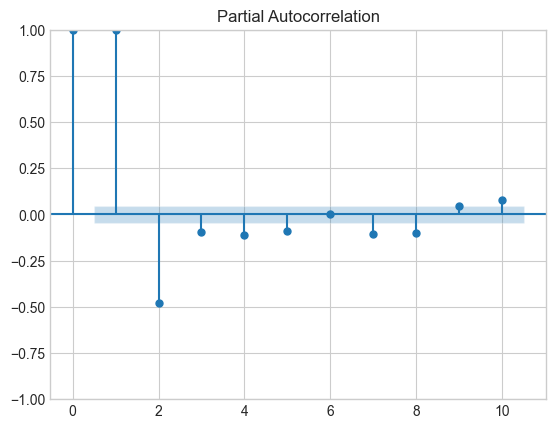

In [ ]:
#Oil's lag
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil = pd.read_csv('oil.csv', parse_dates = ['date'],
                  infer_datetime_format = True, index_col = 'date').to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)
_ = plot_pacf(calendar.avg_oil, lags = 10)

In [ ]:
n_lags = 3
for l in range(1, n_lags + 1):
    calendar[f'oil_lags{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)

In [ ]:
#Holidays
hol = pd.read_csv('holidays_events.csv', parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
hol = hol[hol.locale == 'National']
hol = hol.groupby(hol.index).first()

#Calendar
calendar = calendar.join(hol)
calendar['dofw'] = calendar.index.dayofweek
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True)
calendar = pd.get_dummies(calendar, columns = ['type'])
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True)
print(calendar.shape)
calendar.head()


(1692, 17)


avg_oil  oil_lags1  oil_lags2  oil_lags3  wd  dofw_1  dofw_2  \
2013-01-13  93.284286  93.284286  93.284286  93.218571   0       0       0   
2013-01-14  93.470000  93.284286  93.284286  93.284286   1       0       0   
2013-01-15  93.490000  93.470000  93.284286  93.284286   1       1       0   
2013-01-16  93.644286  93.490000  93.470000  93.284286   1       0       1   
2013-01-17  93.970000  93.644286  93.490000  93.470000   1       0       0   

            dofw_3  dofw_4  dofw_5  dofw_6  type_Additional  type_Bridge  \
2013-01-13       0       0       0       1                0            0   
2013-01-14       0       0       0       0                0            0   
2013-01-15       0       0       0       0                0            0   
2013-01-16       0       0       0       0                0            0   
2013-01-17       1       0       0       0                0            0   

            type_Event  type_Holiday  type_Transfer  type_Work Day  
2013-01-13           0             0              0              0  
2013-01-14           0             0              0              0  
2013-01-15           0             0              0              0  
2013-01-16           0             0              0              0  
2013-01-17           0             0              0              0

In [ ]:
#Wages
calendar['wageday']=0
calendar.loc[(calendar.index.to_timestamp().is_month_end) | (calendar.index.day == 15), 'wageday'] = 1

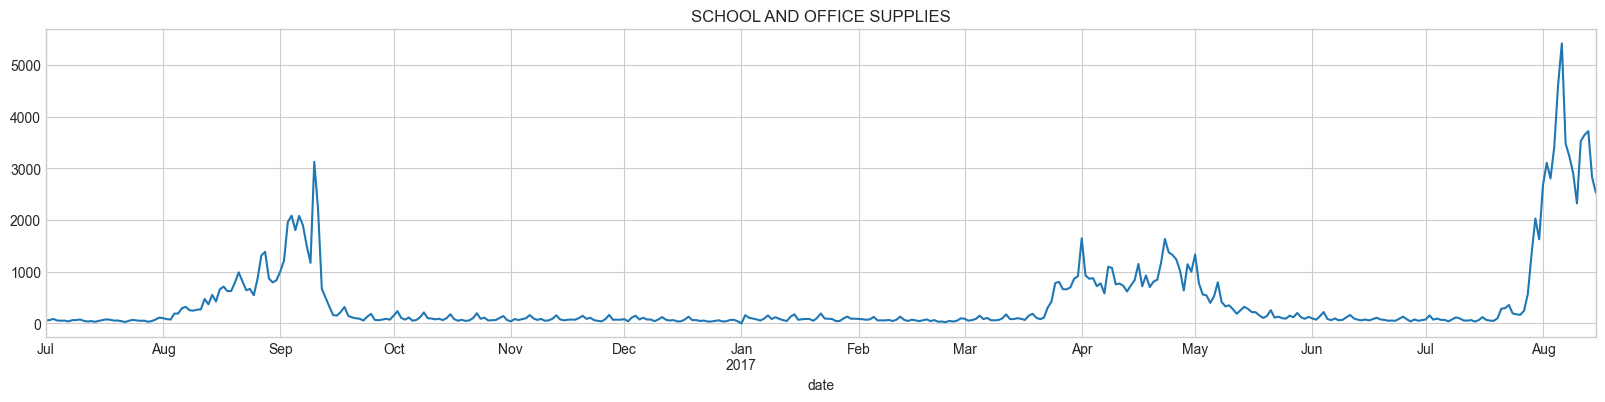

In [ ]:
ax = plt.subplots(1,1,figsize = (20,4))
train.loc["2016-07-01":].filter(like = 'SCHOOL AND OFFICE SUPPLIES', axis=0).groupby(["date"]).sales.sum().plot(title = "SCHOOL AND OFFICE SUPPLIES")
plt.show()

In [ ]:
school_season = []
for i, r in calendar.iterrows():
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season

In [ ]:
c = train.groupby(["store_nbr","family"]).tail(15).groupby(["store_nbr","family"]).sales.sum().reset_index()
c = c[c.sales == 0].drop("sales",axis = 1)
c = c[c.family != "SCHOOL AND OFFICE SUPPLIES"]

In [ ]:
print("Shape of train before zero forecasting:", train.shape)
outer_join = train.reset_index().merge(c, how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
del outer_join
gc.collect()
print("Shape of test before zero forecasting:", test.shape)

Shape of train before zero forecasting: (3000888, 1)
Shape of test before zero forecasting: (28512, 2)


In [ ]:
zero_prediction = []
for i in range(0, len(c)):
    zero_prediction.append(
        pd.DataFrame({"date":pd.date_range("2017-08-16", "2017-08-31").tolist(),"store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],"sales":0}))
zero_prediction = pd.concat(zero_prediction)
zero_prediction['date'] = zero_prediction.date.dt.to_period('D')
del c
gc.collect()
zero_prediction = zero_prediction.set_index(['date', 'store_nbr', 'family'])
zero_prediction.head()

sales
date       store_nbr family          
2017-08-16 1         BABY CARE      0
2017-08-17 1         BABY CARE      0
2017-08-18 1         BABY CARE      0
2017-08-19 1         BABY CARE      0
2017-08-20 1         BABY CARE      0

In [ ]:
#Stores opening dates
a = train.groupby(["date","store_nbr"]).sum().reset_index()
a = a[a["sales"] > 0].groupby("store_nbr")[["date"]].min().sort_values(by="date",ascending = False).head(5)
a.rename(columns = {'date':'open_date'}, inplace = True)
a

open_date
store_nbr            
52         2017-04-20
22         2015-10-09
42         2015-08-21
21         2015-07-24
29         2015-03-20

In [ ]:
# We use next day of start of the latest open store as start
y = train.unstack(['store_nbr', 'family']).loc["2017-04-21":]
fourier = CalendarFourier(freq = 'W', order = 3)
dp = DeterministicProcess(index = y.index, order = 1, seasonal = False,
                          constant = False, additional_terms = [fourier], drop = True)
x = dp.in_sample()
x = x.join(calendar)
x.index.name = "date"

xtest = dp.out_of_sample(steps = 16)
xtest = xtest.join(calendar)
xtest.index.name = "date"

del hol
del calendar
del dp
del oil
_ = gc.collect()

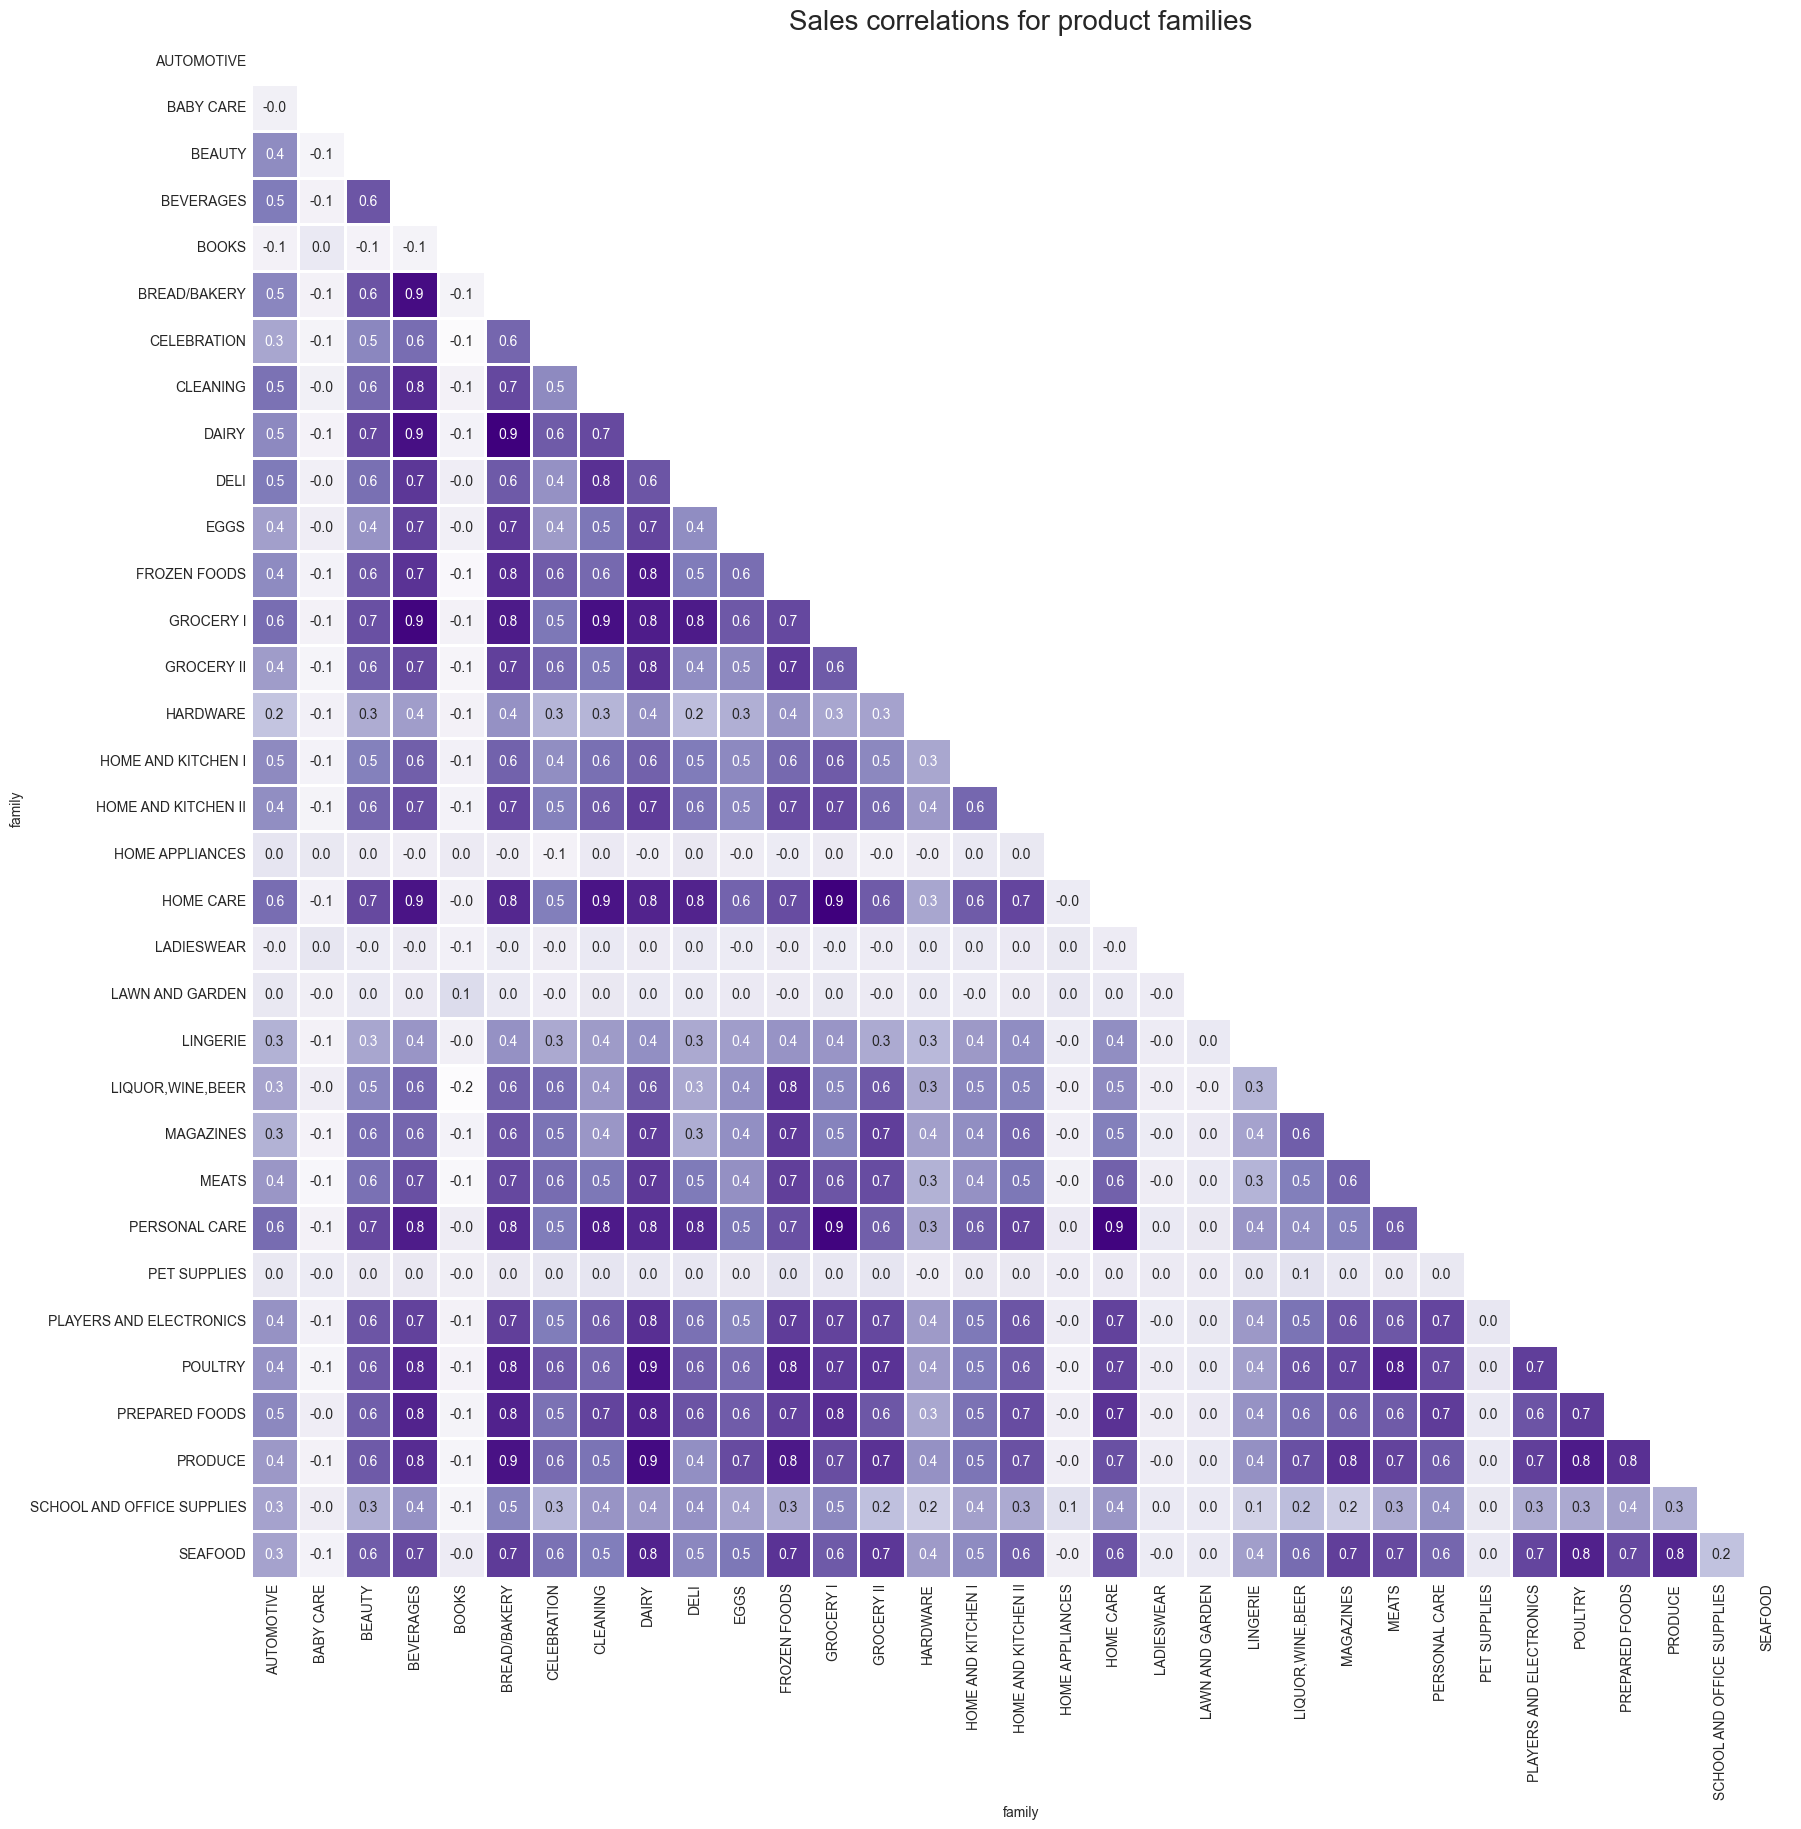

In [ ]:
a = train["2017-04-30":].reset_index()
a["ind"] = 1
a["ind"] = a.groupby("family").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "family", values = "sales").corr(method="spearman")
mask = np.triu(a.corr(method="spearman"))
plt.figure(figsize=(20, 20))
sns.heatmap(a, annot=True, fmt='.1f', cmap='Purples', square=True,
        mask=mask, linewidths=1, cbar=False)
plt.title("Sales correlations for product families",fontsize = 20)
plt.show()

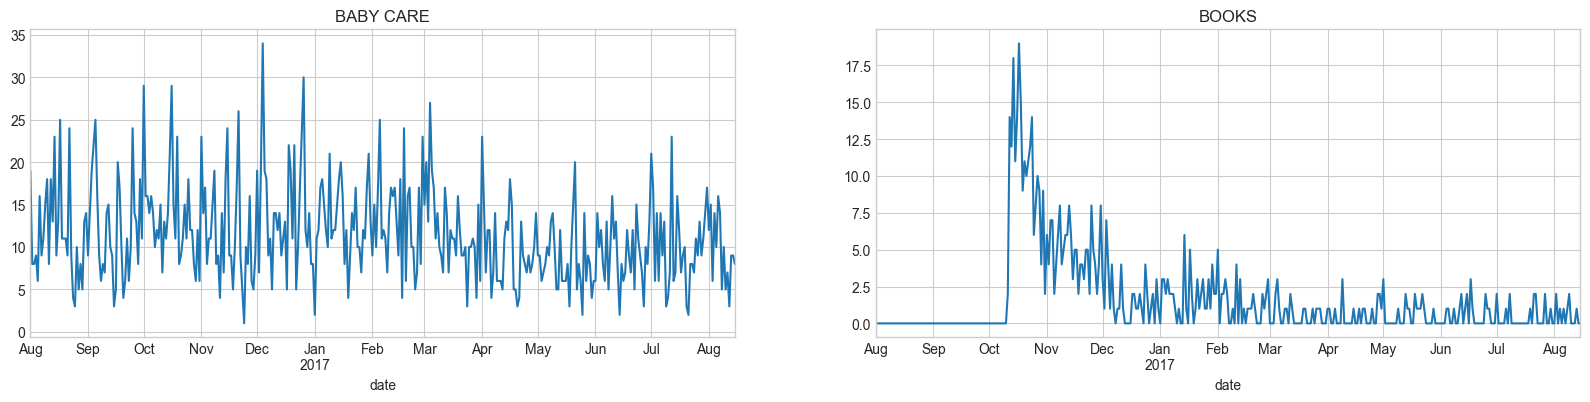

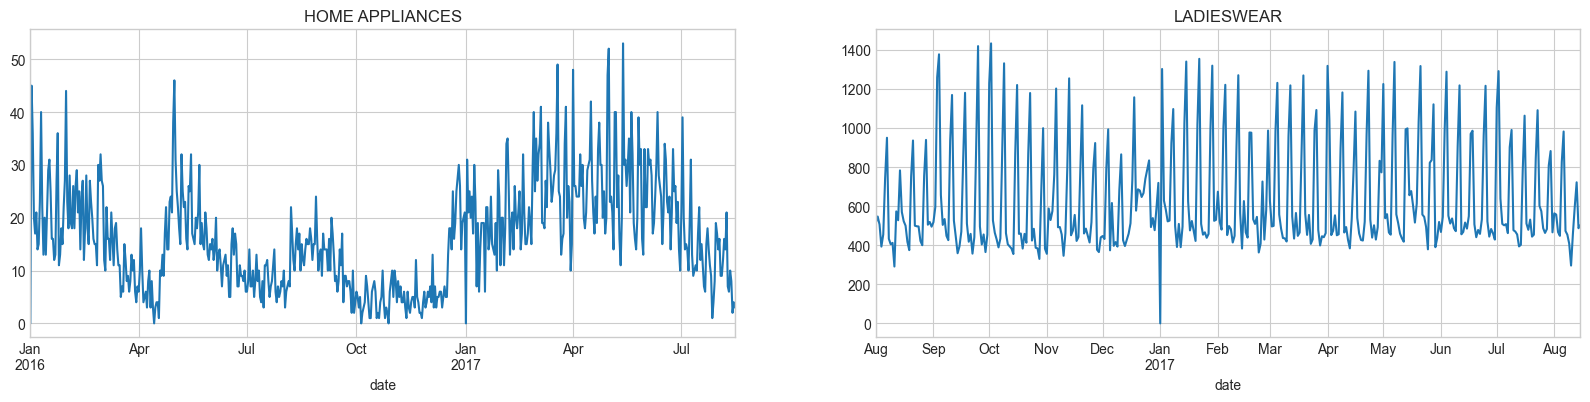

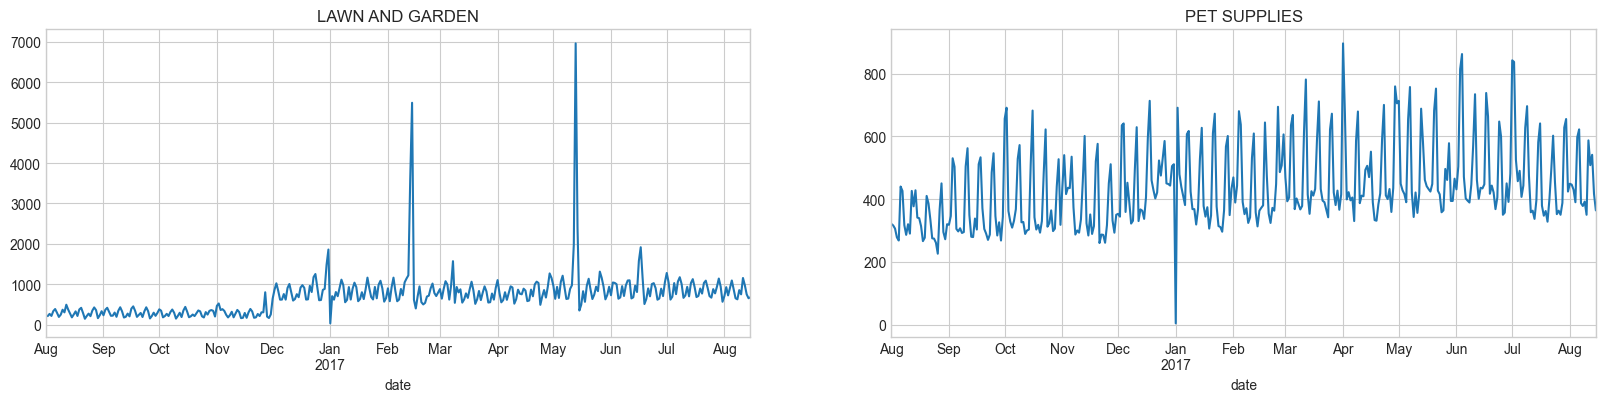

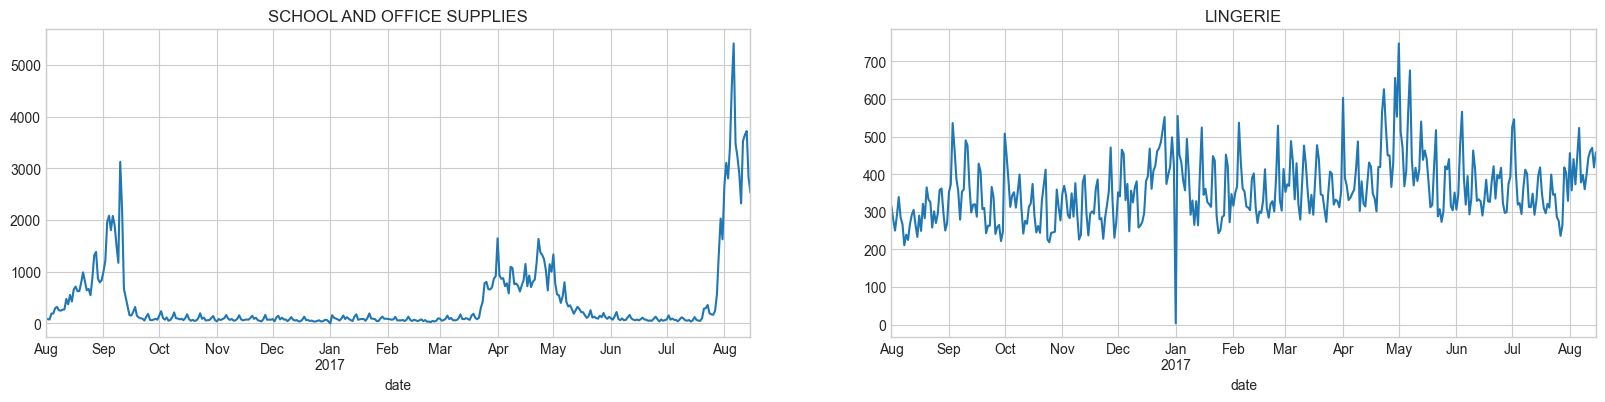

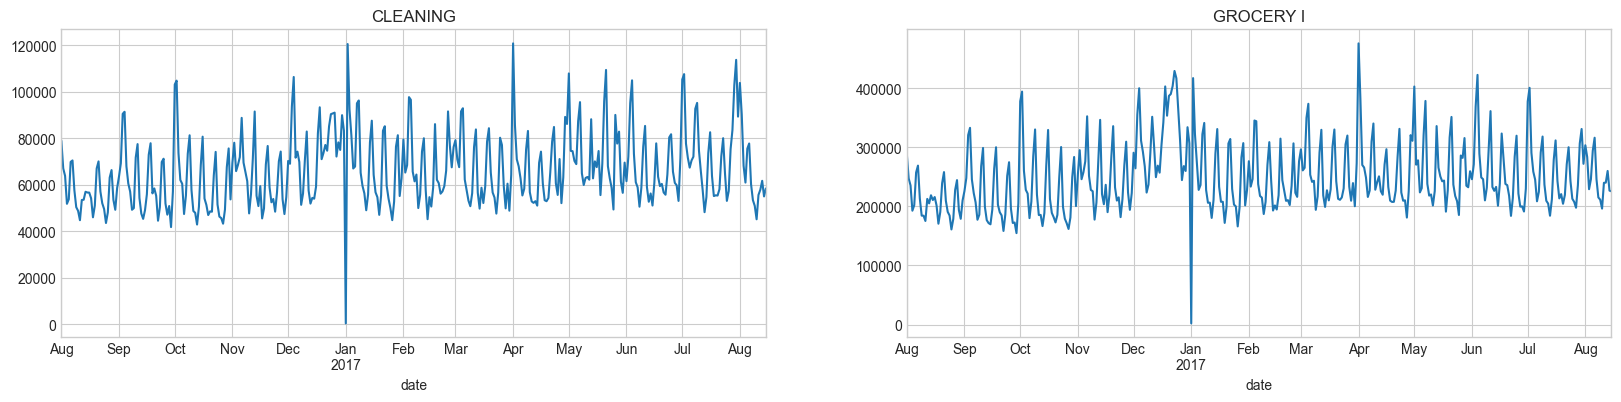

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-08-01":].filter(like = 'BABY CARE', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "BABY CARE")
train.loc["2016-08-01":].filter(like = 'BOOKS', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "BOOKS")
plt.show()
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-01-01":].filter(like = 'HOME APPLIANCES', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "HOME APPLIANCES")
train.loc["2016-08-01":].filter(like = 'LADIESWEAR', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "LADIESWEAR")
plt.show()
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-08-01":].filter(like = 'LAWN AND GARDEN', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "LAWN AND GARDEN")
train.loc["2016-08-01":].filter(like = 'PET SUPPLIES', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "PET SUPPLIES")
plt.show()
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-08-01":].filter(like = 'SCHOOL AND OFFICE SUPPLIES', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "SCHOOL AND OFFICE SUPPLIES")
train.loc["2016-08-01":].filter(like = 'LINGERIE', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "LINGERIE")
plt.show()
fig, ax = plt.subplots(1,2,figsize = (20,4))
train.loc["2016-08-01":].filter(like = 'CLEANING', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[0], title = "CLEANING")
train.loc["2016-08-01":].filter(like = 'GROCERY I', axis=0).groupby(["date"]).sales.sum().plot(ax = ax[1], title = "GROCERY I")
plt.show()

In [ ]:
result = adfuller(np.log1p(y.loc["2016-08-01":, y.columns.get_level_values("family").isin(["PET SUPPLIES"])].mean(axis="columns" )))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["1%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.753177
p-value: 0.403943
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
Failed to Reject Ho - Time Series is Non-Stationary


In [ ]:
non_st_ts = ["SCHOOL AND OFFICE SUPPLIES","BOOKS"]

In [ ]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "sales", title = "Top selling product families")

In [ ]:
low_sales_ts = ["MAGAZINES","LAWN AND GARDEN","BABY CARE",
                "CELEBRATION","GROCERY II","HARDWARE","AUTOMOTIVE",
                "HOME AND KITCHEN I","HOME AND KITCHEN II",
                "HOME APPLIANCES","LINGERIE",
                "LADIESWEAR","SEAFOOD","PLAYERS AND ELECTRONICS",
                "PET SUPPLIES","BEAUTY","PREPARED FOODS",
                "HOME CARE","FROZEN FOODS","EGGS"]
sdate = '2017-04-30'
x=x.loc[sdate:]
y=y.loc[sdate:]
# %pip install -Uq upgini
from upgini import FeaturesEnricher, SearchKey, ModelTaskType
from upgini.metadata import CVType

enricher = FeaturesEnricher(
    search_keys={
        "date": SearchKey.DATE
    },
    country_code = "EC",
    cv = CVType.time_series
)

enriched_ts_map = {}
y_fe_1 = y.loc[:, y.columns.get_level_values("family").isin(["LIQUOR,WINE,BEER"])].mean(axis="columns")
y_fe_2 = y.loc[:, y.columns.get_level_values("family").isin(["CLEANING"])].mean(axis="columns")
y_fe_1 = np.log1p(y_fe_1)
y_fe_2 = np.log1p(y_fe_2)



In [ ]:
%%time

from upgini import FeaturesEnricher, SearchKey, ModelTaskType
from upgini.metadata import RuntimeParameters, CVType

X_enriched = enricher.fit_transform(x.copy().reset_index(), y_fe_1.reset_index(drop=True).values,
    calculate_metrics=True, keep_input=True, max_features=2,).set_index("date")

enriched_ts_map["LIQUOR,WINE,BEER"] = list(set(X_enriched.columns) - set(x.columns))

X_test_enriched = enricher.transform(
    xtest.copy().reset_index(),
    keep_input=True,
    max_features=2,
).set_index("date")

X_enriched2 = enricher.fit_transform(
    X_enriched.reset_index(),
    y_fe_2.reset_index(drop=True).values,
    calculate_metrics=True,
    keep_input=True,
    max_features=2,
).set_index("date")

X_test_enriched2 = enricher.transform(
    X_test_enriched.reset_index(),
    keep_input=True,
    max_features=2,
).set_index("date")

enriched_ts_map["CLEANING"] = list(set(X_enriched2.columns) - set(X_enriched.columns))

print("Number of features, initial -> after enrichment:",x.shape[1],"->",X_enriched2.shape[1])
int_features = set(x.columns.to_list())
ext_features = [col for ext_features_ in enriched_ts_map.values() for col in ext_features_]

x = X_enriched2
xtest = X_test_enriched2
del X_enriched, X_enriched2
del X_test_enriched, X_test_enriched2
del y_fe_1
del y_fe_2
_ = gc.collect()

Detected task type: ModelTaskType.REGRESSION

Columns ['type_Additional', 'type_Bridge', 'type_Event', 'type_Work Day'] has value with frequency more than 99% and has been droped from X



Running search request, search_id=303d90ec-4420-47ab-9be8-de359a479d16
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


2 relevant feature(s) found with the search keys: ['date', 'country_iso_code']


Calculating metrics...
Done

Quality metrics


Match rate  Baseline mean_squared_error  Enriched mean_squared_error  \
                                                                              
Train       100.0                     0.046555                     0.023128   

         Uplift  
                 
Train  0.023428

Done




Running search request, search_id=2493d5d7-22cc-4a0f-b43e-c27b8a7958e0
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Retrieving selected features from data sources...
Done
Detected task type: ModelTaskType.REGRESSION

Columns ['type_Additional', 'type_Bridge', 'type_Event', 'type_Work Day'] has value with frequency more than 99% and has been droped from X



Running search request, search_id=c2b5f746-986b-4ca3-923d-e64ba0e11a89
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


3 relevant feature(s) found with the search keys: ['date', 'country_iso_code']


Calculating metrics...
Done

Quality metrics


Match rate  Baseline mean_squared_error  Enriched mean_squared_error  \
                                                                              
Train       100.0                     0.032438                     0.028009   

         Uplift  
                 
Train  0.004429

Done




Running search request, search_id=679c1a2d-6b31-40d9-9187-ece6d325db03
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Retrieving selected features from data sources...
Done
Number of features, initial -> after enrichment: 26 -> 30
CPU times: total: 16.5 s
Wall time: 10min 21s


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline

lnr_reg = TransformedTargetRegressor(
    regressor = LinearRegression(fit_intercept = True, n_jobs = -1),
    func=np.log1p,
    inverse_func=np.expm1)

lnr = make_pipeline(
    ColumnTransformer([("drop_f", "drop", ext_features)], remainder="passthrough"),
    PowerTransformer(),
    lnr_reg)

lnr.fit(x, y)
yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']

In [ ]:
ylnr = yfit_lnr.append(ypred_lnr)
x = x.join(ylnr)
xtest = xtest.join(ylnr)
del yfit_lnr
del ypred_lnr
del ylnr
_ = gc.collect()

import warnings
from sklearn.linear_model import Ridge, ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

SEED = 6

class CustomRegressor():

    def __init__(self, ext_features = None, knn_features = None, non_st_ts = None, low_sales_ts = None, enriched_ts_map = None, n_jobs=-1):

        self.n_jobs = n_jobs
        self.ext_features = ext_features
        self.knn_features = knn_features
        self.non_st_ts = non_st_ts
        self.low_sales_ts = low_sales_ts
        self.enriched_ts_map = enriched_ts_map
        self.estimators_ = None
        self.product_names_ = None
        self.store_names_ = None

    def _estimator_(self, X, y):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        remove_ext_features = ColumnTransformer([("drop_f", "drop", self.ext_features)],remainder="passthrough")

        if y.name[2] in self.non_st_ts:
            b1 = GradientBoostingRegressor(n_estimators = 175, max_depth=3, loss='huber', random_state=SEED)
            r1 = ExtraTreesRegressor(n_estimators = 250, n_jobs=self.n_jobs, random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=self.n_jobs,
                                  random_state=SEED)
            model = make_pipeline(
                remove_ext_features,
                VotingRegressor ([('gbr', b1), ('et', b2)])
            )

        elif y.name[2] in self.enriched_ts_map.keys():
            ext_features_ = [col for col in self.ext_features if col not in self.enriched_ts_map[y.name[2]]]
            remove_ext_features_ = ColumnTransformer([("drop_f", "drop", ext_features_)],remainder="passthrough")
            power_tr = PowerTransformer()
            ridge = TransformedTargetRegressor(
                regressor = Ridge(fit_intercept=True, solver='auto', alpha=0.7, normalize=True, random_state=SEED),
                func=np.log1p,
                inverse_func=np.expm1)
            ridge_round_to_int = TransformedTargetRegressor(
                regressor=ridge,
                inverse_func=np.rint)
            model = make_pipeline(
                remove_ext_features_,
                power_tr,
                ridge_round_to_int)

        elif y.name[2] in self.low_sales_ts:
            ridge = TransformedTargetRegressor(
                regressor = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=SEED),
                func=np.log1p,
                inverse_func=np.expm1
            )
            svr = TransformedTargetRegressor(
                regressor = SVR(C = 0.2, kernel = 'rbf'),
                func=np.log1p,
                inverse_func=np.expm1
            )
            model = VotingRegressor([('ridge', ridge), ('svr', svr)])

        else:
            ridge = make_pipeline(
                remove_ext_features,
                TransformedTargetRegressor(
                    regressor = Ridge(fit_intercept=True, solver='auto', alpha=0.6, normalize=True, random_state=SEED),
                    func=np.log1p,
                    inverse_func=np.expm1))
            svr = make_pipeline(
                remove_ext_features,
                TransformedTargetRegressor(
                    regressor = SVR(C = 0.2, kernel = 'rbf'),
                    func=np.log1p,
                    inverse_func=np.expm1))
            knn = make_pipeline(
                ColumnTransformer([("selector", "passthrough", self.knn_features)], remainder="drop"),
                PowerTransformer(),
                KNeighborsRegressor(n_neighbors=3, n_jobs=self.n_jobs))
            ard = make_pipeline(
                remove_ext_features,
                TransformedTargetRegressor(
                    regressor = ARDRegression(fit_intercept=True, normalize=True, n_iter=300),
                    func=np.log1p,
                    inverse_func=np.expm1))
            estimators = [('ridge', ridge),('svr', svr),("ard", ard),("knn",knn)]
            model = VotingRegressor(estimators)

        model.fit(X, y)
        return model

    def fit(self, X, y):
        print("Fit stage...")
        self.product_names_ = [str(y.iloc[:, i].name[2]) for i in range(y.shape[1])]
        self.store_names_ = [str(y.iloc[:, i].name[1]) for i in range(y.shape[1])]
        self.estimators_ = []
        for i, n in tqdm(enumerate(self.product_names_)):
            estimator_ = self._estimator_(X.filter(regex= n + "'\)$|\(\d|^[a-zA-Z_0-9., ]+$|\('sales', '" +
            str(y.iloc[:, i].name[1]) + "',", axis=1,),y.iloc[:, i],)
            self.estimators_.append(estimator_)

    def predict(self, X):
        print("Prediction stage...")
        y_pred = []
        for e, n, m in tqdm(zip(self.estimators_, self.product_names_, self.store_names_)):

            y_pred_ = e.predict(X.filter( regex= n + "'\)$|\(\d|^[a-zA-Z_0-9., ]+$|\('sales', '" + m + "',", axis=1,))
            y_pred.append(y_pred_)

        return np.stack(y_pred, axis=1)

In [ ]:

knn_features = list(int_features - set(['oil_lags2', 'oil_lags1',"trend"]))
model = CustomRegressor(ext_features, knn_features, non_st_ts, low_sales_ts, enriched_ts_map, n_jobs=-1)
model.fit(x, y)

y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y.columns)

Fit stage...


1658it [05:34,  4.96it/s]


Prediction stage...


1658it [00:28, 58.80it/s]


In [ ]:
from sklearn.metrics import mean_squared_log_error as msle
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_ = y.stack(['store_nbr', 'family']).clip(0.)
y_['pred'] = y_pred.values
print(y_.groupby('family').apply(lambda r : np.sqrt(np.sqrt(msle(r['sales'], r['pred'])))))
print('RMSLE : ', np.sqrt(np.sqrt(msle(y_['sales'], y_['pred']))))

family
AUTOMOTIVE                    0.683478
BABY CARE                     0.594298
BEAUTY                        0.684615
BEVERAGES                     0.389473
BOOKS                         0.282261
BREAD/BAKERY                  0.355627
CELEBRATION                   0.706161
CLEANING                      0.487619
DAIRY                         0.338115
DELI                          0.379857
EGGS                          0.516515
FROZEN FOODS                  0.503754
GROCERY I                     0.369234
GROCERY II                    0.709905
HARDWARE                      0.694118
HOME AND KITCHEN I            0.659819
HOME AND KITCHEN II           0.624364
HOME APPLIANCES               0.610248
HOME CARE                     0.429842
LADIESWEAR                    0.696618
LAWN AND GARDEN               0.689495
LINGERIE                      0.751659
LIQUOR,WINE,BEER              0.637745
MAGAZINES                     0.673559
MEATS                         0.397790
PERSONAL CARE     

In [ ]:
ypred = pd.DataFrame(model.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)
ypred = ypred.stack(['store_nbr', 'family'])
ypred = ypred.append(zero_prediction).sort_index()
sub = pd.read_csv('sample_submission.csv')
sub['sales'] = ypred.values
sub.to_csv('submission.csv', index = False)

Prediction stage...


1658it [00:25, 65.88it/s]
